## Demo using the gymnasium environment for dynamic foraging


Install some helper plotting functions

In [2]:
try:
    import aind_dynamic_foraging_basic_analysis
except:
    !pip install aind-dynamic-foraging-basic-analysis --quiet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

from aind_behavior_gym.gym_env.dynamic_bandit_env import DynamicBanditEnv
from aind_behavior_gym.dynamic_foraging_tasks.coupled_block_task import CoupledBlockTask
from aind_behavior_gym.dynamic_foraging_tasks.uncoupled_block_task import UncoupledBlockTask
from aind_behavior_gym.dynamic_foraging_tasks.random_walk_task import RandomWalkTask

from aind_dynamic_foraging_basic_analysis import plot_foraging_session

Define a random agent

In [3]:
class RandomAgent():
    def __init__(self, k_arms, seed=None):
        self.rng = np.random.default_rng(seed)
        self.k_arms = k_arms
        
    def act(self, state):
        return self.rng.integers(0, self.k_arms)

### A random agent performing the Coupled task

In [3]:
task = CoupledBlockTask(block_min=40, block_max=80, block_beta=20)
env = DynamicBanditEnv(task, num_trials=1000)
random_agent = RandomAgent(k_arms=env.action_space.n, seed=42)

observation, info = env.reset(seed=42)
done = False
actions = []
rewards = []

while not done:  # Trial loop
    # Choose an action
    action = random_agent.act(observation)
    
    # Take the action and observe the next observation and reward
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated        
    
    # Move to the next observation
    observation = next_observation
    
    actions.append(action)
    rewards.append(reward)

Plot the session

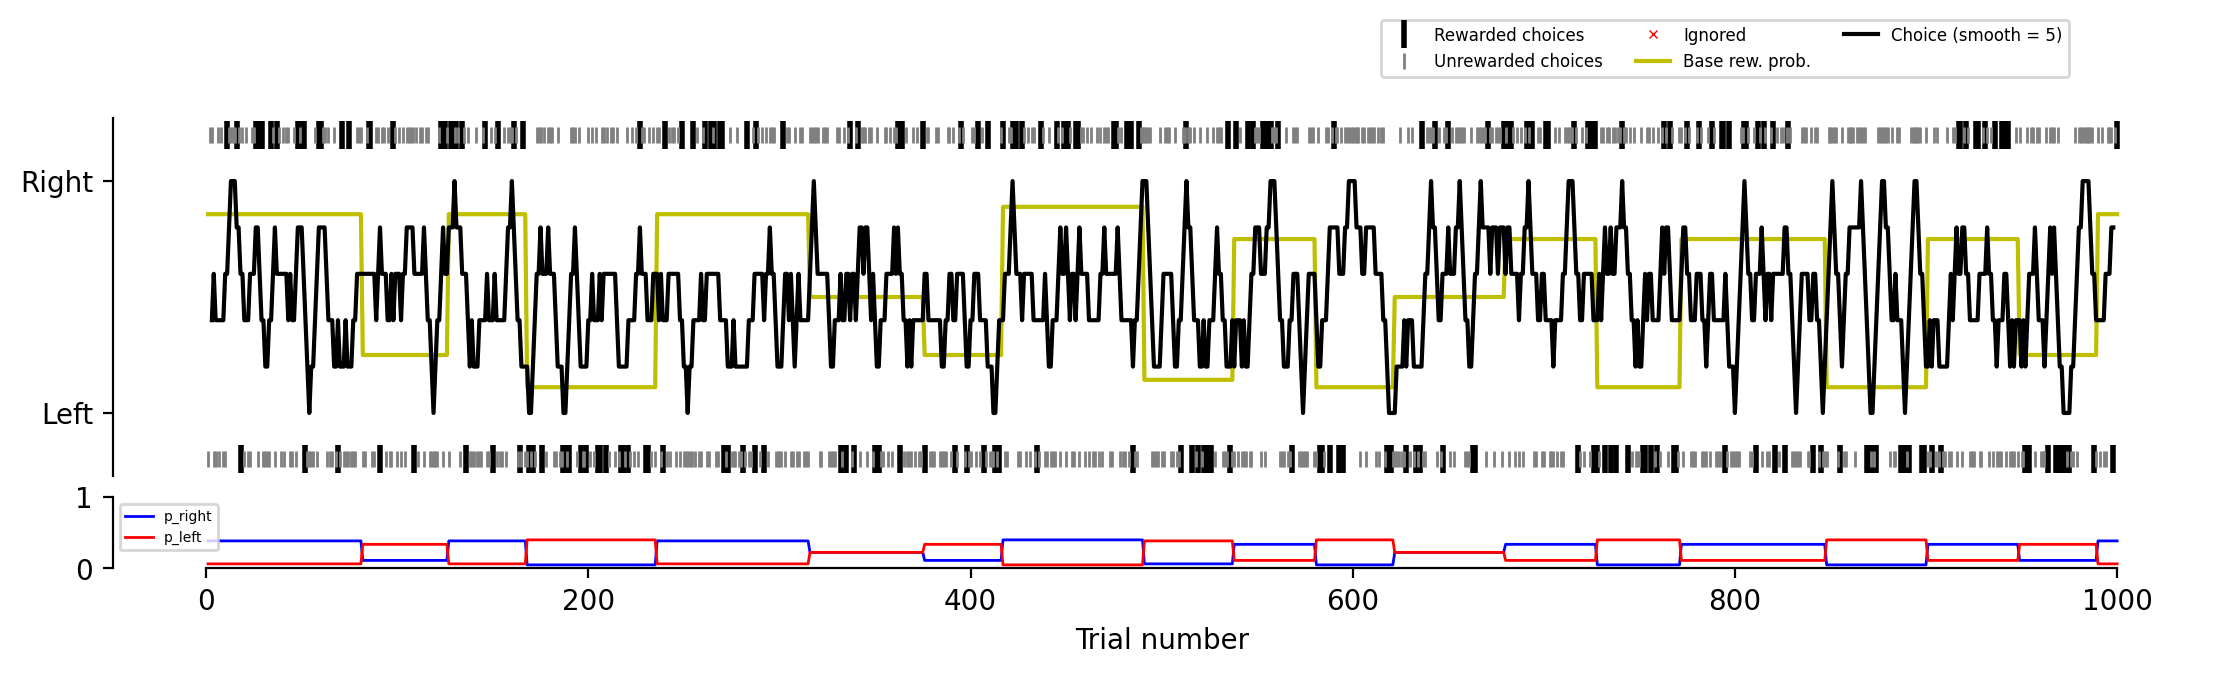

In [4]:
plot_foraging_session(choice_history=actions,
                            reward_history=rewards,
                            p_reward=np.array(env.task.trial_p_reward).T);

### A left-biased agent (with ignore) performing the Uncoupled task

In [5]:
L, R, IGNORE = 0, 1, 2

task = UncoupledBlockTask(
    rwd_prob_array=[0.1, 0.5, 0.9],
    block_min=20, block_max=35,
    persev_add=True, perseverative_limit=4,
    max_block_tally=4,  # Max number of consecutive blocks in which one side has higher rwd prob than the other
)

env = DynamicBanditEnv(
    task, 
    num_arms=2,
    allow_ignore=True,
    num_trials=1000
)

observation, info = env.reset(seed=42)
done = False
actions = []
rewards = []

rng = np.random.default_rng(seed=42) # Another independent random number generator

while not done:  # Trial loop
    # Choose an action (a random agent with left bias and ignores)
    action = [L, R, IGNORE][rng.choice([0]*100 + [1]*20 + [2]*1)]
    
    # Can also apply block holde here (optional)
    task.hold_this_block = 500 < task.trial < 700
    
    # Take the action and observe the next observation and reward
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated        
    
    # Move to the next observation
    observation = next_observation
    
    actions.append(action)
    rewards.append(reward)

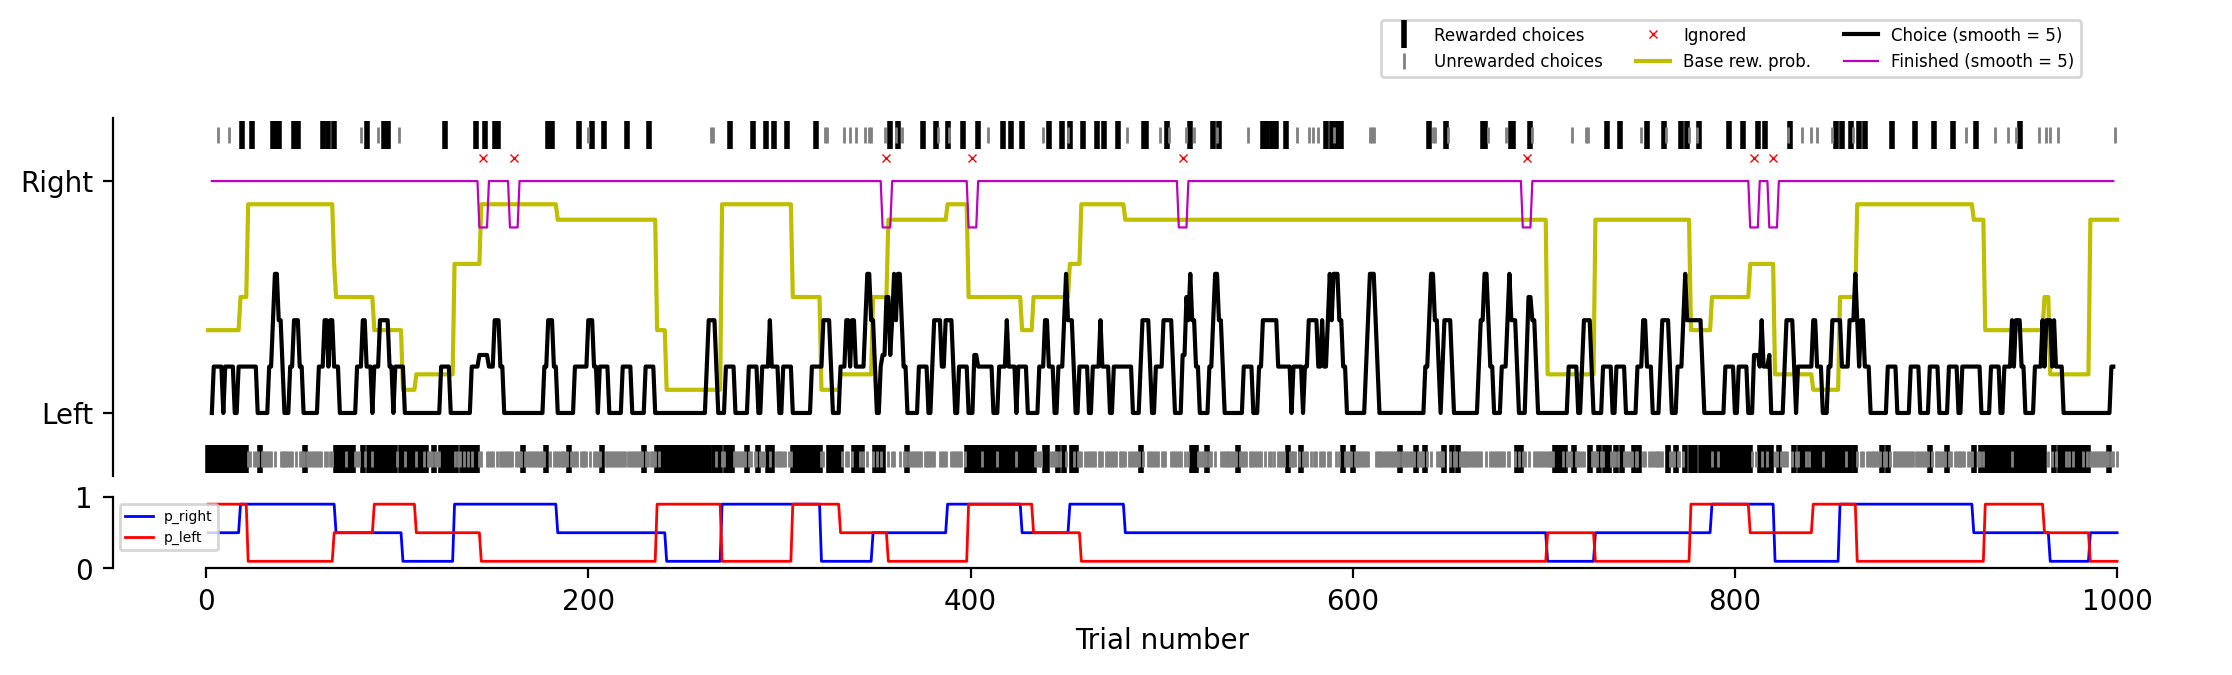

In [6]:
actions = np.array(actions).astype(float)
actions[actions==IGNORE] = np.nan
plot_foraging_session(choice_history=actions,
                      reward_history=rewards,
                      p_reward=np.array(env.task.trial_p_reward).T);

Also show reasons of block transitions

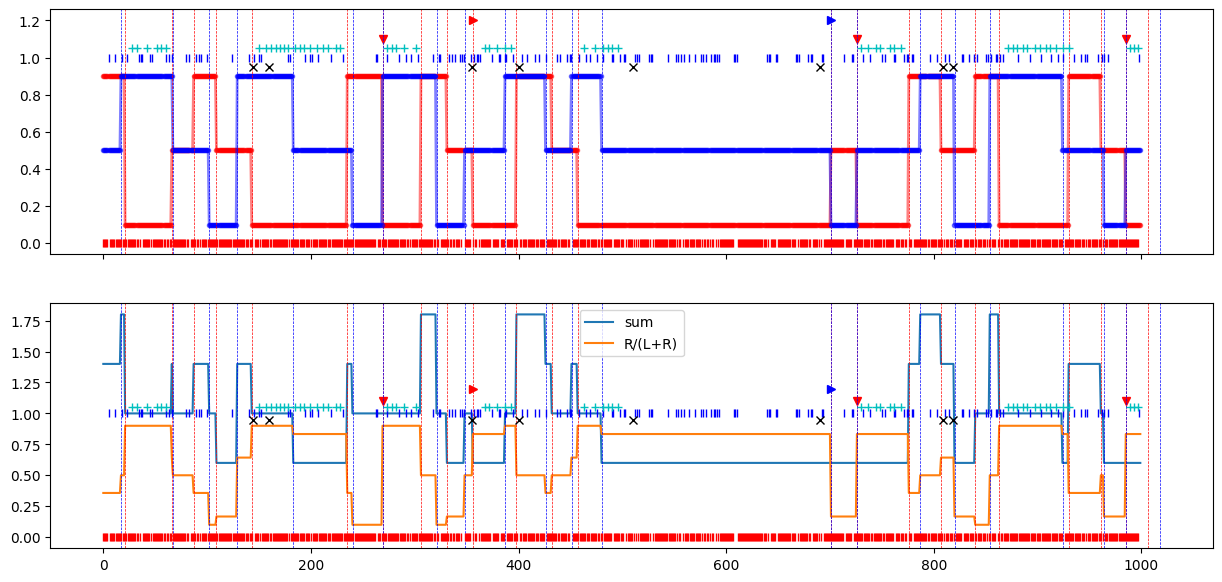

In [7]:
task.plot_reward_schedule();

### A random agent performing a random walk task

In [15]:
L, R, IGNORE = 0, 1, 2

task = RandomWalkTask(
        p_min=[0.1, 0.1],  # The lower bound of p_L and p_R
        p_max=[0.9, 0.9],  # The upper bound
        sigma=[0.1, 0.1],  # The mean of each step of the random walk
        mean=[0, 0],  # The mean of each step of the random walk
    )

env = DynamicBanditEnv(
    task, 
    num_arms=2,
    allow_ignore=False,
    num_trials=1000,
)

agent = RandomAgent(k_arms=env.action_space.n, seed=42)

observation, info = env.reset(seed=42)
done = False
actions = []
rewards = []

while not done:  # Trial loop
    # Choose an action (a random agent with left bias and ignores)
    action = agent.act(observation)
        
    # Take the action and observe the next observation and reward
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated        
    
    # Move to the next observation
    observation = next_observation
    
    actions.append(action)
    rewards.append(reward)

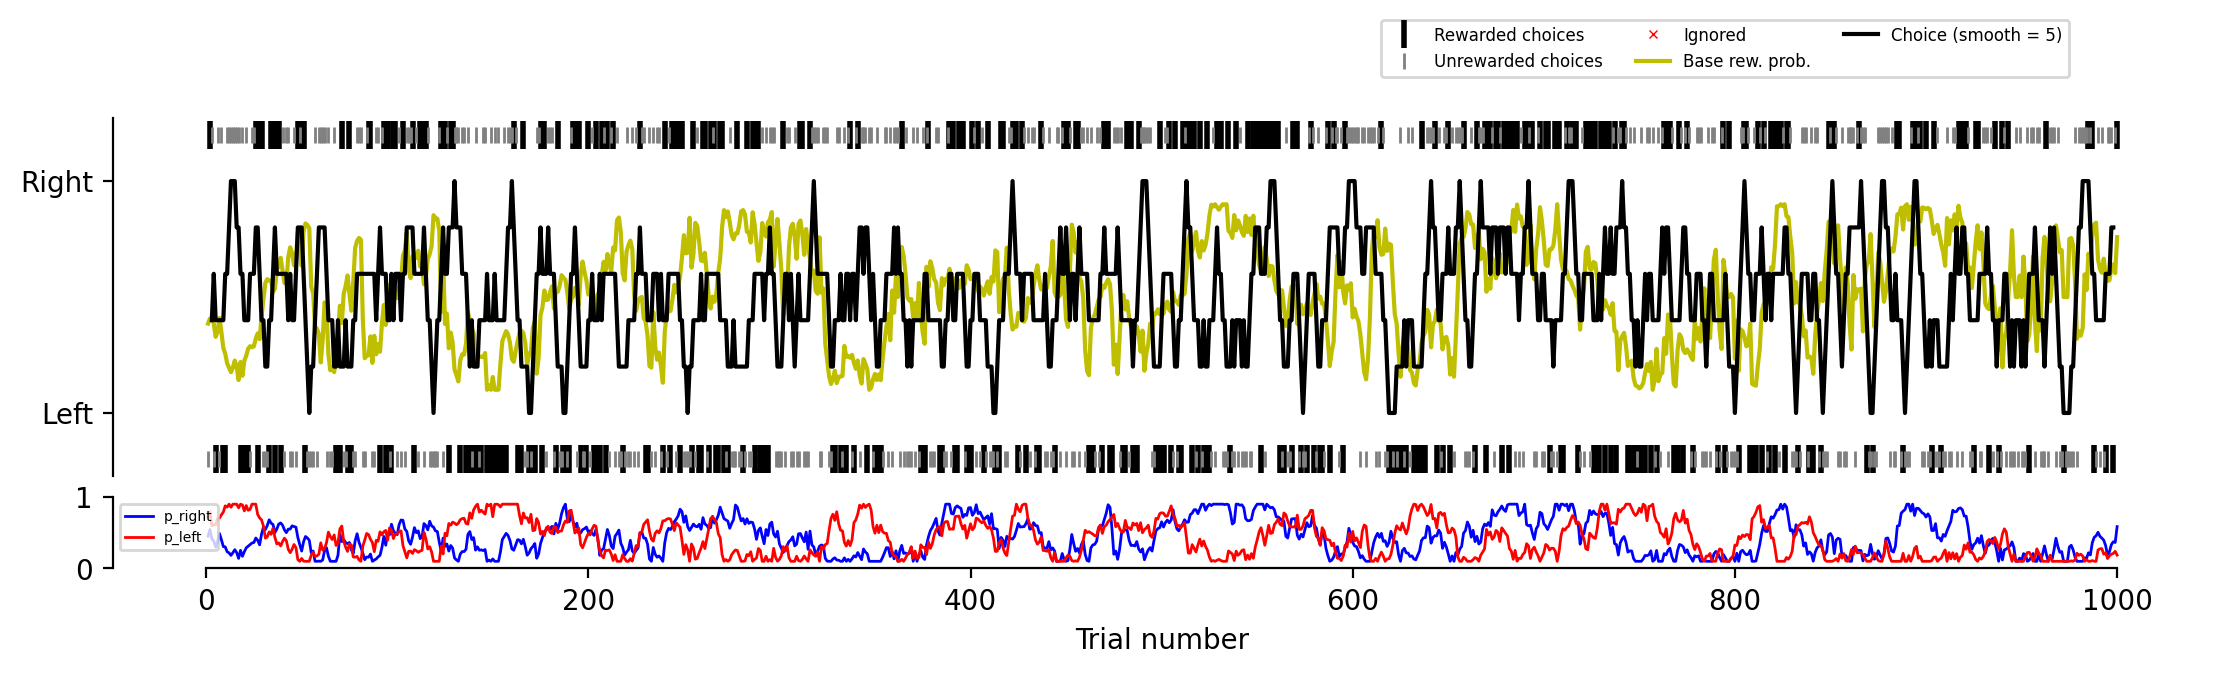

In [17]:
actions = np.array(actions).astype(float)
actions[actions==IGNORE] = np.nan
plot_foraging_session(choice_history=actions,
                      reward_history=rewards,
                      p_reward=np.array(env.task.trial_p_reward).T);

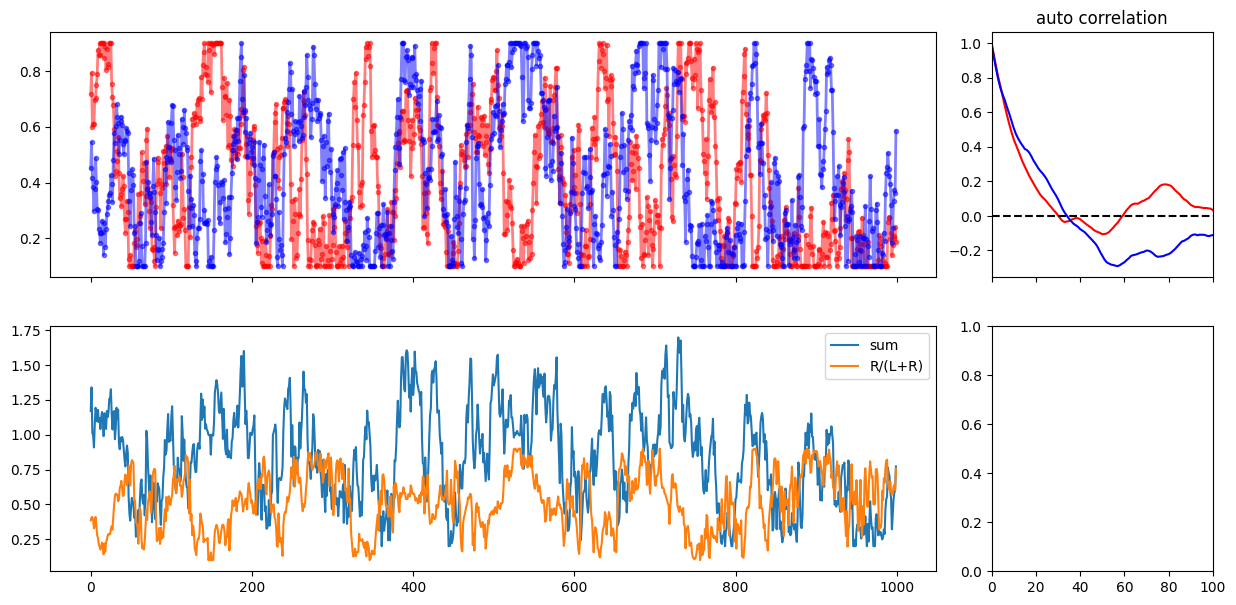

In [16]:
task.plot_reward_schedule();